# Lab 1
## Классификация возраста, пола и расы по лицу человека
### Комлева Юлия РИМ-281226

Используйте публичные данные UTKfaces. https://susanqq.github.io/UTKFace/
В работе необходимо использовать данные Aligned&Cropped Faces, где произведены вырезы лиц с исходных изображений.

Изображения хранятся в формате jpg. В имени (почти!!!) каждого иображения имеется информации о человеке

$$[возраст]\_[пол]\_[раса]\_[время].jpg$$

Потребуются первые три параметра из названия каждого файлы.

В текущем файле реализована тренировка сверточной нейронной сети resnet50 для классификации возраста по фотографии. Текущая СНС используется с предобученными весами (transfer learning - перенос обучения) на датасете imagenet. Перенос обучения позволяет использовать веса сети с другого набора данных. Как правило, такой подход позволяет существенно поднять точность предсказания на новом наборе данных.

Задачи:
1. Переписать класс Dataset так, чтобы __getitem__ выдывал классы возраст, пол и раса. Задача регрессии для предсказания возраста является сложно, в этой связи будем решать ее как классификационную. Необходимо закодировать возраст в один из классов [(0, 5), (5, 14), (14, 30), (30, 45), (45, 60), (60, 120)], таким образом __getitem__ будет выдавать номер класса, которому принадлежит человек на фотографии.
Дополнительная задача (по желанию): при классификации ответом является возрастная, а не число. Можно получать возраст в числом выражении если использовать математическое ожидание по ответам нейронной сети. Для этого необходимо умножить ответы в виде Softmax на средние значения возраста в каждой группе и проссумировать все значения. 

2. Переписать класс Net. Добавить Mobilentv2 и Resnet34, так чтобы аргументом net можно было выбрать на основе какого экстрактора признаков построить сеть для классификации. Добавить дополнительные классификаторы для возраста и расы.

3. Обучить сеть. Попробуйте оптимизатор SGD и Adam. Визуализировать результаты на валидационном наборе данных.

Примечание: для тренировки лучше использовать GPU или colab.research.google.com с поддержкой GPU.

In [29]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Ниже реализован класс Dataset, который имеет три обязательных метода __init__, __len__, __getitem__.

- __init__ происходит инициализация переменных датасета.
- __len__ возращает количество изображений в датасете.
- __getitem__ возвращает изображение в формате PIL и значения классов age, gender, race по индексу.

Размер изображения установить $224 \times 224$. В случае медленного обучения на процессоре параметр можно уменьшить, но потребуется произвести изменения в месте крепления экстрактора признаков и классификатора нейронной сети.

In [30]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(), # [0,255] -> [0.0, 1.0]
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # below zero 
    
])

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        names = [os.path.join(path, it) for it in names]
        np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]
        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]
        

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)
    

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.ids[index]

        image = Image.open(ID)

        # Load data and get label
        age = int(ID.split('\\')[-1].split('_')[0])
        gender = int(ID.split('\\')[-1].split('_')[1])
        race = int(ID.split('\\')[-1].split('_')[2])
        
        

        for i in range(6):
            group_age = range(self.age_list[i][0], self.age_list[i][1])
            if age in group_age:
                age = i

        
        
        if self.transform:
            image = self.transform(image)
        
        return image, age, gender, race

In [31]:
path = os.path.join('W:', os.sep, 'datasets', 'UTKFace')
train_data = Dataset(path, subset='train', test_part = 0.8, transform = T) #0.2
valid_data = Dataset(path, subset='valid', test_part = 0.8, transform = T)

In [32]:
print('train data len: ', train_data.__len__())
print('valid data len: ', valid_data.__len__())

train data len:  18964
valid data len:  4741


Ниже представлен пример получения изображения по индексу.

In [33]:
train_data[138]

(tensor([[[0.4588, 0.4549, 0.4510,  ..., 0.3686, 0.3725, 0.3804],
          [0.4588, 0.4588, 0.4549,  ..., 0.3686, 0.3725, 0.3804],
          [0.4588, 0.4588, 0.4549,  ..., 0.3725, 0.3725, 0.3804],
          ...,
          [0.8549, 0.8549, 0.8549,  ..., 0.9882, 0.9882, 0.9882],
          [0.8549, 0.8549, 0.8549,  ..., 0.9882, 0.9882, 0.9882],
          [0.8549, 0.8549, 0.8549,  ..., 0.9882, 0.9882, 0.9882]],
 
         [[0.4588, 0.4549, 0.4510,  ..., 0.2980, 0.3020, 0.3098],
          [0.4588, 0.4588, 0.4549,  ..., 0.2980, 0.3020, 0.3098],
          [0.4588, 0.4588, 0.4549,  ..., 0.2980, 0.3020, 0.3098],
          ...,
          [0.6706, 0.6706, 0.6706,  ..., 0.9961, 0.9961, 0.9961],
          [0.6706, 0.6706, 0.6706,  ..., 0.9961, 0.9961, 0.9961],
          [0.6706, 0.6706, 0.6706,  ..., 0.9961, 0.9961, 0.9961]],
 
         [[0.4275, 0.4235, 0.4196,  ..., 0.2588, 0.2627, 0.2706],
          [0.4275, 0.4275, 0.4235,  ..., 0.2588, 0.2627, 0.2706],
          [0.4275, 0.4275, 0.4235,  ...,

In [34]:
gender_dict = {0:"male", 1:"female"}
race_dict = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others(Hispanic, Latino, Middle Eastern)"}
age_dict = {0:"0-5", 1:"5-14", 2:"14-30", 3:"30-45", 4:"45-60", 5:"60+"}

In [35]:
#gender_dict.get(0)

age group:  30-45
gender:  male
race:  White


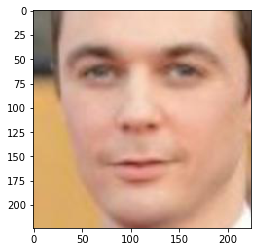

In [36]:
img, age, gender, race = train_data[138]
print("age group: ", age_dict.get(age))
print("gender: ", gender_dict.get(gender))
print("race: ", race_dict.get(race))
plt.imshow(img.numpy().transpose(1,2,0));

Объекты train_data и valid_data передадим в DataLoader. Объект train_loader и valid_loader будут выдавать пачку изображения с правильными ответами (батчи).

In [37]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=8, 
                                           shuffle=True)

# download and transform test dataset
valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=8, 
                                          shuffle=False)

age:     tensor([3, 4, 2, 3, 3, 3, 3, 0])
gender:  tensor([1, 0, 0, 1, 0, 0, 1, 1])
race:    tensor([0, 1, 0, 3, 1, 4, 0, 4])


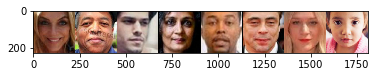

In [38]:
images, age, gender, race = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print("age:    ", age)
print("gender: ", gender)
print("race:   ", race)

In [39]:
import torch.nn as nn
import torch.nn.functional as F

In [40]:
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn.functional as F

class MTLnet(nn.Module): #Multi-task learning
    def __init__(self, net='mobilenetv2', pretrained=True):
        super(MTLnet, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            self.model = models.mobilenet_v2(pretrained)
            self.model.classifier = nn.Dropout(p=0.2, inplace=False)
                #nn.Linear(in_features=1280, out_features=1000, bias=True)
            
            self.model.gender_cls = nn.Linear(1280 * 7 * 7, 2)
            self.model.age_cls = nn.Linear(1280 * 7 * 7, 6)
            self.model.race_cls = nn.Linear(1280 * 7 * 7, 5)
            
            
        elif self.net == 'resnet34':
            self.model = models.resnet34(pretrained)
            self.model.gender_cls = nn.Linear(512, 2)
            self.model.age_cls = nn.Linear(512, 6)
            self.model.race_cls = nn.Linear(512, 5)
        elif self.net == 'resnet50':
            self.model = models.resnet50(pretrained) # initialize the resnet50
            self.model.gender_cls = nn.Linear(2048, 2)
            self.model.age_cls = nn.Linear(2048, 6)
            self.model.race_cls = nn.Linear(2048, 5)

    def forward(self, x):
        if (self.net == 'resnet50') or (self.net == 'resnet34'):
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x) # without last fully connected(2048, 1000) layer
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)
        
        if self.net == 'mobilenetv2':
            x = self.model.features(x)
            x = self.model.classifier(x) # only dropout
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)

        
        return age, gender, race


In [42]:
#model = MTLnet(net='resnet50').to(device)
#model = MTLnet(net='resnet34').to(device)
#model = MTLnet(net='mobilenetv2', pretrained=True).to(device)
model = MTLnet(net='resnet34', pretrained=False).to(device)
#model.to(device)


In [43]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9)
#optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [44]:
epochs = 10
x = list(range(1, epochs + 1))
loss_list = []
val_loss_list = []
accuracy_age_list = []
v_accuracy_age_list = []
accuracy_gender_list = []
v_accuracy_gender_list = []
accuracy_race_list = []
v_accuracy_race_list = []

In [45]:
%%time
from IPython.display import clear_output
print("epoch|loss |val_loss| age(acc/v_acc)|gender(acc/v_acc)|race(acc/v_acc)|")
for epoch in range(epochs):  # loop over the dataset multiple times

    for phase in ['train', 'valid']:
        
        if phase == 'train':
            
            model.train(True)
            
            running_loss = 0.0
            correct = 0
            total = 0

            age_correct = 0
            gender_correct = 0
            race_correct = 0
            
            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, age, gender, race = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                out_age, out_gender, out_race = model(inputs)

                loss_age = criterion(out_age, age)
                loss_gender = criterion(out_gender, gender)
                loss_race = criterion(out_race, race)
                
                loss = loss_age + loss_gender + loss_race

                loss.backward()
                
                optimizer.step()
                
                

                # print statistics
                running_loss += loss.item()

                _, age_pred = torch.max(out_age.data, 1)
                _, gender_pred = torch.max(out_gender.data, 1)
                _, race_pred = torch.max(out_race.data, 1)
                
                total += gender.size(0)
                
                age_correct += (age_pred == age).sum().item()
                gender_correct += (gender_pred == gender).sum().item()
                race_correct += (race_pred == race).sum().item()
            
            
            
        elif phase == 'valid':
            
            model.train(False)
            
            validation_loss = 0.
            v_correct = 0
            v_total = 0
            
            v_age_correct = 0
            v_gender_correct = 0
            v_race_correct = 0

            for i, v_data in enumerate(valid_loader):
                v_loss_age = 0
                v_loss_gender = 0
                v_loss_race = 0
                
                v_inputs, v_age, v_gender, v_race = v_data[0].to(device), v_data[1].to(device), v_data[2].to(device), v_data[3].to(device)

                v_out_age, v_out_gender, v_out_race = model(v_inputs)


                v_loss_age += criterion(v_out_age, v_age)
                v_loss_gender += criterion(v_out_gender, v_gender)
                v_loss_race += criterion(v_out_race, v_race)

                validation_loss += v_loss_age.item() + v_loss_gender.item() + v_loss_race.item()

                _, v_age_pred = torch.max(v_out_age.data, 1)
                _, v_gender_pred = torch.max(v_out_gender.data, 1)
                _, v_race_pred = torch.max(v_out_race.data, 1)

                v_total += v_gender.size(0)
                
                v_age_correct += (v_age_pred == v_age).sum().item()
                v_gender_correct += (v_gender_pred == v_gender).sum().item()
                v_race_correct += (v_race_pred == v_race).sum().item()
    #print("epoch|loss |val_loss|age(acc/v_acc)|gender(acc/v_acc)|race(acc/v_acc)|")
    print('%5d|%.3f| %.3f  | %.3f / %.3f |  %.3f / %.3f  | %.3f / %.3f |' %
          (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
           age_correct / total, v_age_correct / v_total,
           gender_correct / total, v_gender_correct / v_total,
           race_correct / total, v_race_correct / v_total,))           
    
    loss_list.append(running_loss / len(train_loader))
    val_loss_list.append(validation_loss / len(valid_loader))
    
    accuracy_age_list.append(age_correct / total)
    v_accuracy_age_list.append(v_age_correct / v_total)
    
    accuracy_gender_list.append(gender_correct / total)
    v_accuracy_gender_list.append(v_gender_correct / v_total)
    
    accuracy_race_list.append(race_correct / total)
    v_accuracy_race_list.append(v_race_correct / v_total)
    #print(scheduler.get_lr())
    #scheduler.step() # learning rate decay
    
print('Finished Training')

epoch|loss |val_loss| age(acc/v_acc)|gender(acc/v_acc)|race(acc/v_acc)|
    1|3.722| 3.605  | 0.355 / 0.366 |  0.562 / 0.621  | 0.426 / 0.469 |
    2|3.587| 3.489  | 0.358 / 0.371 |  0.629 / 0.641  | 0.459 / 0.498 |
    3|3.508| 3.421  | 0.364 / 0.386 |  0.652 / 0.659  | 0.473 / 0.503 |
    4|3.457| 3.372  | 0.376 / 0.396 |  0.666 / 0.673  | 0.477 / 0.507 |
    5|3.418| 3.329  | 0.382 / 0.400 |  0.677 / 0.679  | 0.483 / 0.512 |
    6|3.378| 3.299  | 0.390 / 0.405 |  0.687 / 0.698  | 0.488 / 0.508 |
    7|3.332| 3.228  | 0.396 / 0.411 |  0.695 / 0.708  | 0.495 / 0.521 |
    8|3.271| 3.189  | 0.405 / 0.416 |  0.708 / 0.718  | 0.501 / 0.536 |
    9|3.197| 3.072  | 0.422 / 0.440 |  0.725 / 0.745  | 0.509 / 0.549 |
   10|3.131| 3.003  | 0.432 / 0.450 |  0.735 / 0.762  | 0.521 / 0.564 |
Finished Training
Wall time: 37min 25s


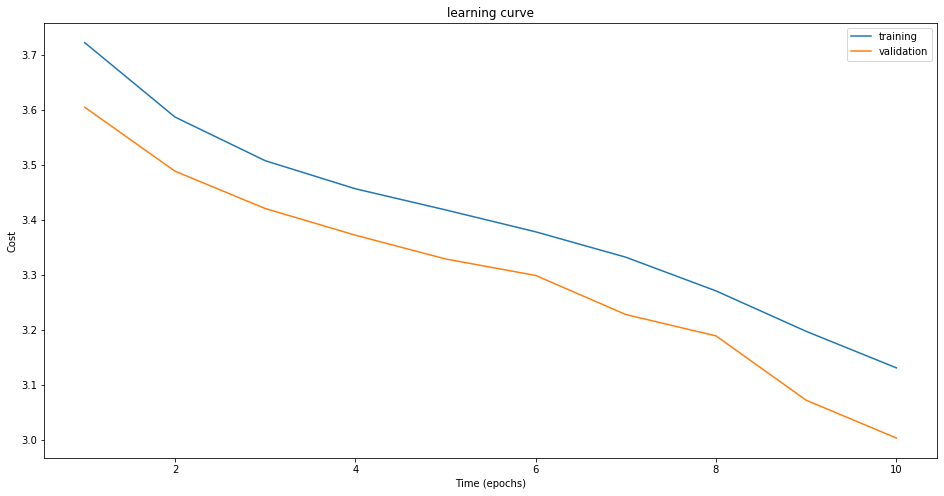

In [46]:
plt.figure(figsize=(16,8))
plt.title("learning curve")
plt.plot(x, loss_list, label= 'training')
plt.plot(x, val_loss_list, label= 'validation')
plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.legend();

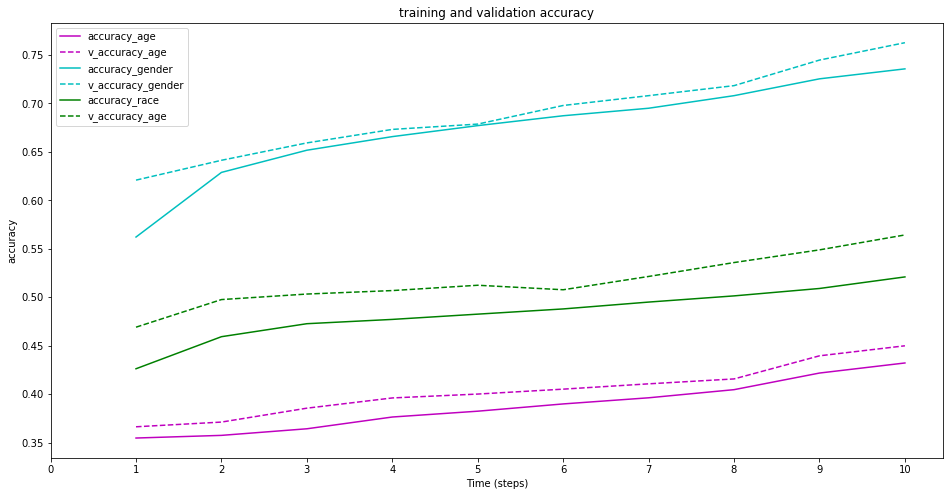

In [47]:
plt.figure(figsize=(16,8))
plt.title("training and validation accuracy")
plt.plot(x, accuracy_age_list, 'm', label = 'accuracy_age')
plt.plot(x, v_accuracy_age_list, 'm--', label = 'v_accuracy_age')

plt.plot(x, accuracy_gender_list, 'c', label = 'accuracy_gender')
plt.plot(x, v_accuracy_gender_list, 'c--', label = 'v_accuracy_gender')

plt.plot(x, accuracy_race_list, 'g', label = 'accuracy_race')
plt.plot(x, v_accuracy_race_list, 'g--', label = 'v_accuracy_age')
plt.xticks(range(0, 11))
plt.xlabel("Time (steps)")
plt.ylabel("accuracy")
plt.legend();

In [48]:
df = pd.DataFrame()
df['training loss'] = loss_list
df['validation loss'] = val_loss_list
df['accuracy age'] = accuracy_age_list
df['validation accuracy age'] = v_accuracy_age_list
df['accuracy gender'] = accuracy_gender_list
df['validation accuracy gender'] = v_accuracy_gender_list
df['accuracy race'] = accuracy_race_list
df['validation accuracy race'] = v_accuracy_race_list
path = 'C:\\Users\\usr\\Documents\\GitHub\\dl\\2-UTKFace\\9.csv'
df.to_csv(path, index=False)
pd.read_csv('9.csv')

,training loss,validation loss,accuracy age,validation accuracy age,accuracy gender,validation accuracy gender,accuracy race,validation accuracy race
0,3.722187,3.604772,0.354777,0.366378,0.562065,0.620755,0.426229,0.469099
1,3.587009,3.488524,0.357520,0.371230,0.628718,0.641215,0.459291,0.497574
2,3.507645,3.420716,0.364322,0.385573,0.651603,0.659144,0.472685,0.503269
3,3.456574,3.372151,0.376450,0.396119,0.665630,0.673065,0.477115,0.506855
4,3.418150,3.328986,0.382462,0.400127,0.676967,0.678549,0.482546,0.512339
5,3.378255,3.298904,0.389949,0.405189,0.687144,0.697743,0.487924,0.507699
6,3.332080,3.227841,0.396277,0.410673,0.694896,0.707868,0.494991,0.521409
7,3.270810,3.188994,0.404661,0.415735,0.707868,0.718203,0.501371,0.535752
8,3.197278,3.072004,0.421799,0.439570,0.725216,0.744569,0.509017,0.548829
9,3.130900,3.003303,0.432187,0.449905,0.735499,0.762497,0.520934,0.564227


In [143]:
#path = 'C:\\Users\\usr\\Documents\\GitHub\\dl\\2-UTKFace\\UTKFace_MTL_ResNet50.pth'
#torch.save(model.state_dict(), path)

# Results
## Stats
- 10 epochs
- train data len:  18964 
- valid data len:  4741

|file|nn|optimizer|lr|lr decay gamma|pretrained|time  
|---|---|---|---|---|---
|1.csv|ResNet50|SGD|1e-5|0|True|54min 44s   
|2.csv|ResNet50|SGD|1e-5|0|True|54min 35s   
|3.csv|ResNet34|SGD|1e-5|0|True|37min 36s   
|4.csv|MobileNetv2|Adam|1e-3|True|0|55min 5s   
|5.csv|MobileNetv2|SGD|1e-3|True|0|41min 9s   
|6.csv|MobileNetv2|SGD|1e-6|True|0|43min 23s   
|7.csv|MobileNetv2|SGD|1e-2|True|0.5|43min 7s   
|8.csv|MobileNetv2|SGD|1e-3|True|0.9|42min 19s   
|9.csv|ResNet34|SGD|1e-5|0|False|37min 25s


### 0. ResNet34, ResNet50, MobileNetv2 learning curves
- 5.csv	MobileNetv2	SGD	1e-3
- 1.csv	ResNet50	SGD	1e-5	
- 3.csv	ResNet34	SGD	1e-5	

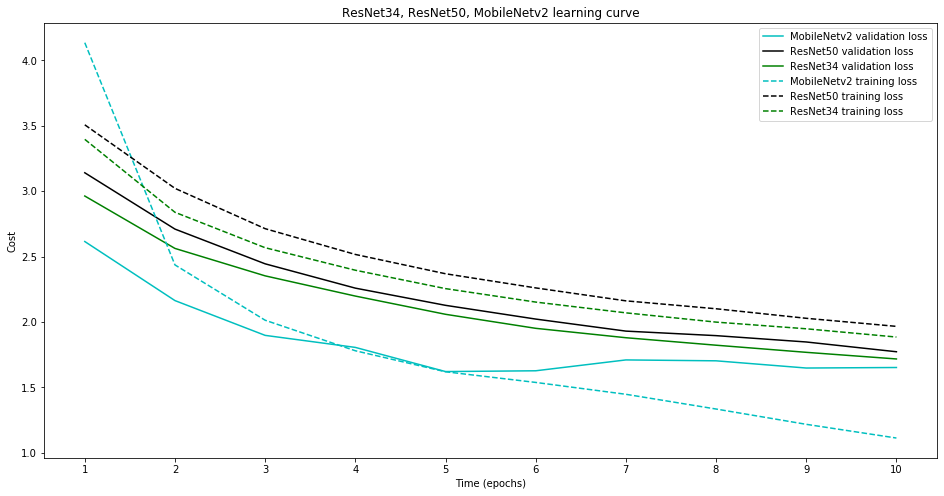

In [82]:
# learning rate
df_mobile = pd.read_csv('5.csv') # lr=1e-3
df_resnet50 = pd.read_csv('1.csv') # lr=1e-5
df_resnet34 = pd.read_csv('3.csv') # lr=1e-5

plt.figure(figsize=(16,8))
plt.title("ResNet34, ResNet50, MobileNetv2 learning curve")

plt.plot(x, df_mobile['validation loss'], 'c', label = 'MobileNetv2 validation loss')
plt.plot(x, df_resnet50['validation loss'], 'k', label = 'ResNet50 validation loss')
plt.plot(x, df_resnet34['validation loss'], 'g', label = 'ResNet34 validation loss')

plt.plot(x, df_mobile['training loss'], 'c--', label = 'MobileNetv2 training loss')
plt.plot(x, df_resnet50['training loss'], 'k--', label = 'ResNet50 training loss')
plt.plot(x, df_resnet34['training loss'], 'g--', label = 'ResNet34 training loss')

plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.xticks(range(1, 11))
plt.legend();

### 1. ResNet50 learning curve with and without normalization (imagenet) 
- _no effect_

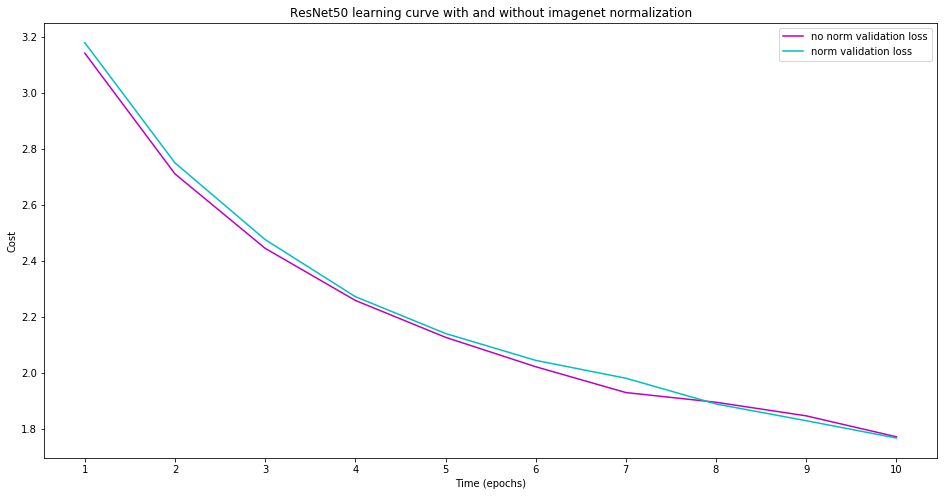

In [77]:
# normalization
df_resnet50_no_norm = pd.read_csv('1.csv') #lr=1e-5
df_resnet50_norm = pd.read_csv('2.csv') #lr=1e-5

x = list(range(1, 11))
plt.figure(figsize=(16,8))
plt.title("ResNet50 learning curve with and without imagenet normalization")
plt.plot(x, df_resnet50_no_norm['validation loss'], 'm', label = 'no norm validation loss')
plt.plot(x, df_resnet50_norm['validation loss'], 'c', label = 'norm validation loss')
plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.xticks(range(1, 11))
plt.legend();

### 2. MobileNetv2 learning curve with different learning rate
- 5.csv	MobileNetv2	SGD	1e-3	
- 6.csv	MobileNetv2	SGD	1e-6	
- 7.csv	MobileNetv2	SGD	1e-2	gamma 0.5	
- 8.csv	MobileNetv2	SGD	1e-3	gamma 0.9	

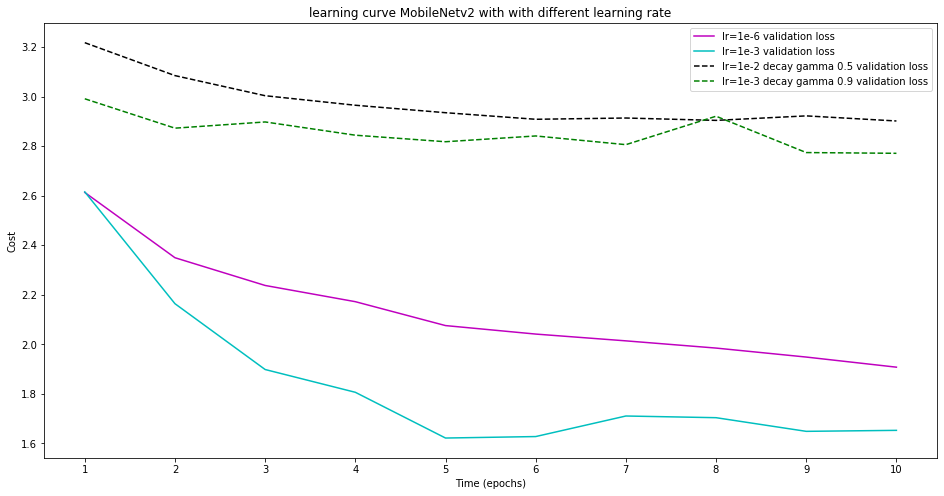

In [83]:
# learning rate
df_mobile_lr3 = pd.read_csv('5.csv') # lr=1e-3
df_mobile_lr6 = pd.read_csv('6.csv') # lr=1e-6
df_mobile_lr_decay = pd.read_csv('7.csv') # learning rate decay (exp)
df_mobile_lr_decay2 = pd.read_csv('8.csv') # learning rate decay (exp)
plt.figure(figsize=(16,8))
plt.title("learning curve MobileNetv2 with with different learning rate")

plt.plot(x, df_mobile_lr6['validation loss'], 'm', label = 'lr=1e-6 validation loss')
plt.plot(x, df_mobile_lr3['validation loss'], 'c', label = 'lr=1e-3 validation loss')
plt.plot(x, df_mobile_lr_decay['validation loss'], 'k--', label = 'lr=1e-2 decay gamma 0.5 validation loss')
plt.plot(x, df_mobile_lr_decay2['validation loss'], 'g--', label = 'lr=1e-3 decay gamma 0.9 validation loss')

plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.xticks(range(1, 11))
plt.legend();

### 3. MobileNetv2 learning curve with different optimizers
- 4.csv	MobileNetv2	Adam	1e-3	0	55min 5s
- 5.csv	MobileNetv2	SGD	1e-3	0	41min 9s

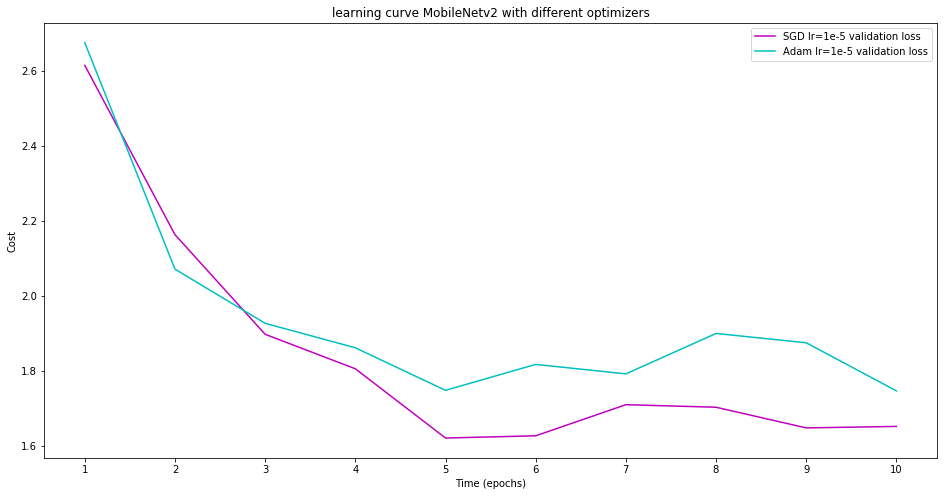

In [84]:
# optimizer
df_mobile_Adam = pd.read_csv('4.csv') # Adam lr=1e-5
df_mobile_SGD = pd.read_csv('5.csv') # SGD lr=1e-5

plt.figure(figsize=(16,8))
plt.title("learning curve MobileNetv2 with different optimizers")
plt.plot(x, df_mobile_SGD['validation loss'], 'm', label = 'SGD lr=1e-5 validation loss')
plt.plot(x, df_mobile_Adam['validation loss'], 'c', label = 'Adam lr=1e-5 validation loss')
plt.xticks(range(1, 11))

plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.legend();

### 4. ResNet34, ResNet50, MobileNetv2 learning curves

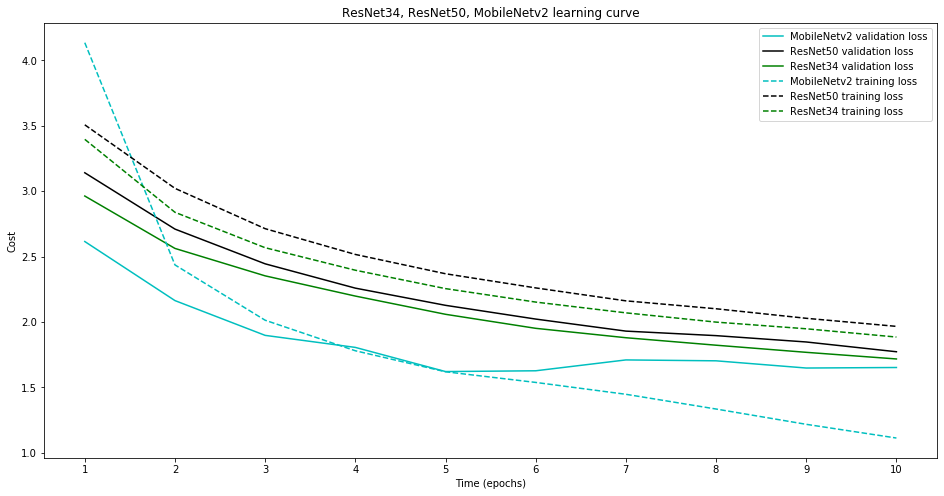

In [85]:
# learning rate
df_mobile = pd.read_csv('5.csv') # lr=1e-3
df_resnet50 = pd.read_csv('1.csv') # lr=1e-5
df_resnet34 = pd.read_csv('3.csv') # lr=1e-5

plt.figure(figsize=(16,8))
plt.title("ResNet34, ResNet50, MobileNetv2 learning curve")

plt.plot(x, df_mobile['validation loss'], 'c', label = 'MobileNetv2 validation loss')
plt.plot(x, df_resnet50['validation loss'], 'k', label = 'ResNet50 validation loss')
plt.plot(x, df_resnet34['validation loss'], 'g', label = 'ResNet34 validation loss')

plt.plot(x, df_mobile['training loss'], 'c--', label = 'MobileNetv2 training loss')
plt.plot(x, df_resnet50['training loss'], 'k--', label = 'ResNet50 training loss')
plt.plot(x, df_resnet34['training loss'], 'g--', label = 'ResNet34 training loss')

plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.xticks(range(1, 11))
plt.legend();

### 4. ResNet50 accuracy

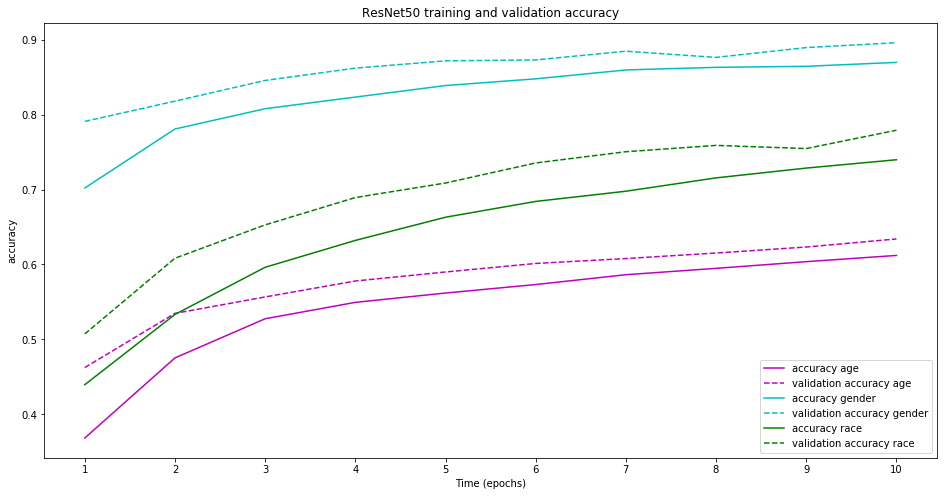

In [128]:
df = pd.read_csv('1.csv') # 1.csv ResNet50 SGD lr=1e-5 

x = list(range(1, 11))
plt.figure(figsize=(16,8))
plt.title("ResNet50 training and validation accuracy")

plt.plot(x, df['accuracy age'], 'm', label = 'accuracy age')
plt.plot(x, df['validation accuracy age'], 'm--', label = 'validation accuracy age')

plt.plot(x, df['accuracy gender'], 'c', label = 'accuracy gender')
plt.plot(x, df['validation accuracy gender'], 'c--', label = 'validation accuracy gender')

plt.plot(x, df['accuracy race'], 'g', label = 'accuracy race')
plt.plot(x, df['validation accuracy race'], 'g--', label = 'validation accuracy race')
plt.xticks(range(1, 11))
plt.xlabel("Time (epochs)")
plt.ylabel("accuracy")
plt.legend();

### 5. ResNet34 accuracy

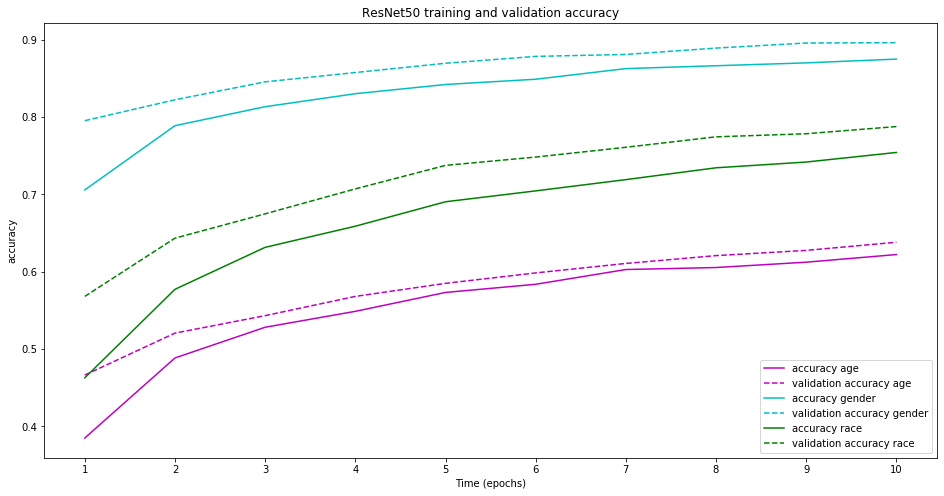

In [152]:
df = pd.read_csv('3.csv') # SGD lr=1e-5 

x = list(range(1, 11))
plt.figure(figsize=(16,8))
plt.title("ResNet50 training and validation accuracy")

plt.plot(x, df['accuracy age'], 'm', label = 'accuracy age')
plt.plot(x, df['validation accuracy age'], 'm--', label = 'validation accuracy age')

plt.plot(x, df['accuracy gender'], 'c', label = 'accuracy gender')
plt.plot(x, df['validation accuracy gender'], 'c--', label = 'validation accuracy gender')

plt.plot(x, df['accuracy race'], 'g', label = 'accuracy race')
plt.plot(x, df['validation accuracy race'], 'g--', label = 'validation accuracy race')
plt.xticks(range(1, 11))
plt.xlabel("Time (epochs)")
plt.ylabel("accuracy")
plt.legend();

### 6. MobileNetv2 accuracy
### 3-4-5 epochs

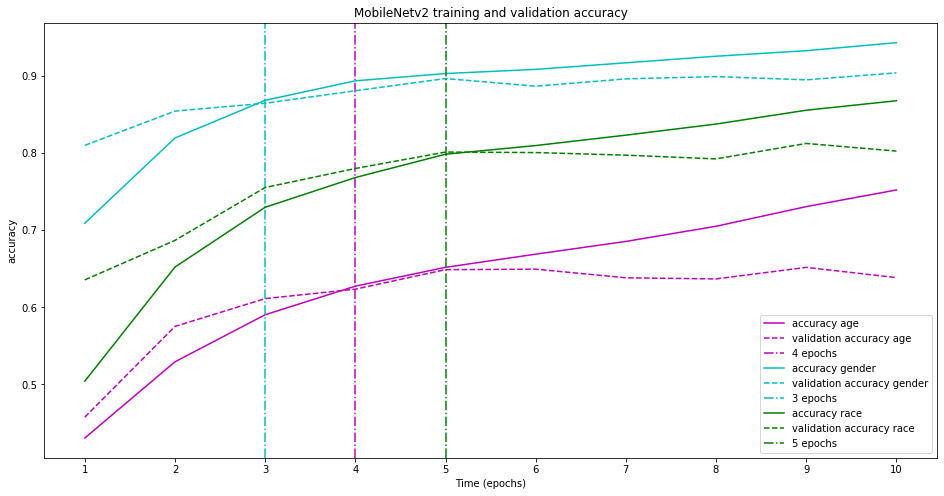

In [65]:
df = pd.read_csv('5.csv') 

x = list(range(1, 11))
plt.figure(figsize=(16,8))
plt.title("MobileNetv2 training and validation accuracy")

plt.plot(x, df['accuracy age'], 'm', label = 'accuracy age')
plt.plot(x, df['validation accuracy age'], 'm--', label = 'validation accuracy age')
plt.axvline(x = 4, color='m', linestyle='-.', label = '4 epochs')

plt.plot(x, df['accuracy gender'], 'c', label = 'accuracy gender')
plt.plot(x, df['validation accuracy gender'], 'c--', label = 'validation accuracy gender')
plt.axvline(x = 3, color='c', linestyle='-.', label = '3 epochs')

plt.plot(x, df['accuracy race'], 'g', label = 'accuracy race')
plt.plot(x, df['validation accuracy race'], 'g--', label = 'validation accuracy race')
plt.axvline(x = 5, color='g', linestyle='-.', label = '5 epochs')

plt.xticks(range(1, 11))
plt.xlabel("Time (epochs)")
plt.ylabel("accuracy")
plt.legend();

### 7. Pretrained ResNet34: True/False 

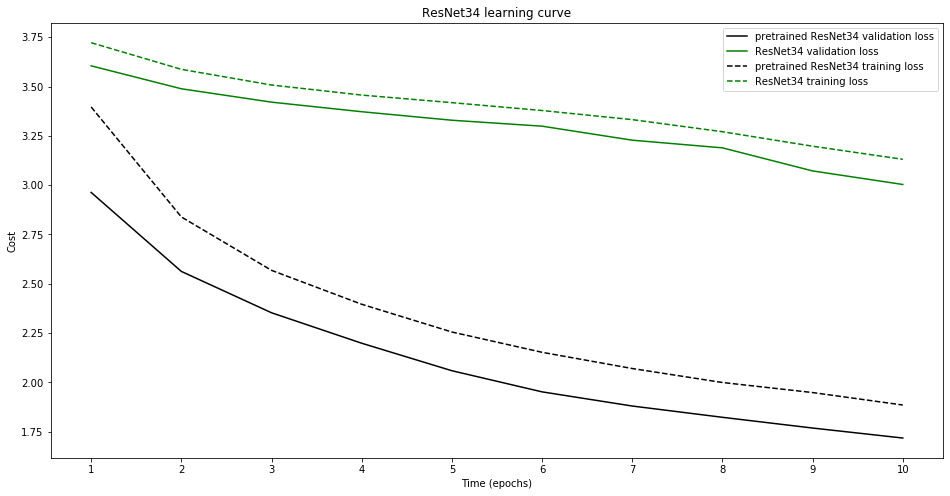

In [49]:
df_resnet34_pretrained = pd.read_csv('3.csv') # lr=1e-5
df_resnet34 = pd.read_csv('9.csv') # lr=1e-5
plt.figure(figsize=(16,8))
plt.title("ResNet34 learning curve")


plt.plot(x, df_resnet34_pretrained['validation loss'], 'k', label = 'pretrained ResNet34 validation loss')
plt.plot(x, df_resnet34_pretrained['training loss'], 'k--', label = 'pretrained ResNet34 training loss')

plt.plot(x, df_resnet34['validation loss'], 'g', label = 'ResNet34 validation loss')

plt.plot(x, df_resnet34['training loss'], 'g--', label = 'ResNet34 training loss')

plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.xticks(range(1, 11))
plt.legend();